# EE219 Project 3

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   
surprise v0.1  
scikit-surprise v1.0.5


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
import os
from logging.config import fileConfig

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

GET_DATA_FROM_FILES = True

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', 
                       values='rating').values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [14]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = len(r_data.rating.tolist())
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

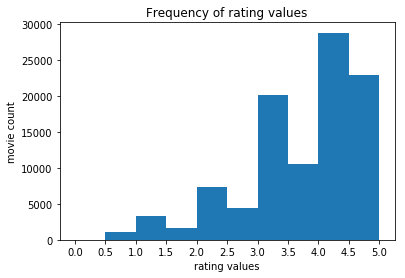

In [15]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

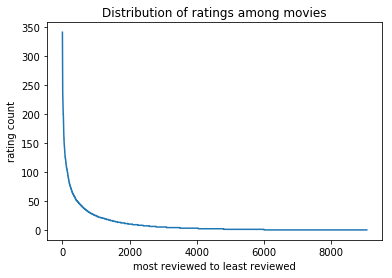

In [16]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(~np.isnan(R), axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

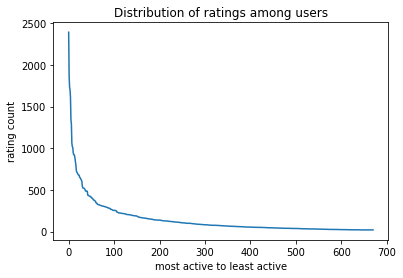

In [17]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(~np.isnan(R), axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

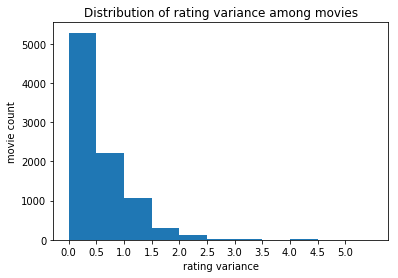

In [18]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.nanvar(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()

#### Question 7

$I_u$ : Set of item indices for which ratings have been specifed by user $u$  
$I_v$ : Set of item indices for which ratings have been specifed by user $v$  
$\mu_u$ : Mean rating for user $u$ computed using her specifed ratings  
$r_{uk}$ : Rating of user $u$ for item $k$  

$$\mu_u = \frac{\Sigma_{i\in I_{u}} r_{ui}}{\mid I_u \mid}$$

#### Question 8

$I_{u} \cap I_{v}$ represents the indices of movies that are rated by both user $u$ and user $v$. It's possible that this intersection be the empty set ($\emptyset$), given the sparsity of the matrix. It happens when user $u$ has not rated any movie that user $v$ has.

#### Question 9

#### Question 10

In [19]:
import surprise
from surprise import Dataset
from surprise.model_selection import cross_validate
data = Dataset.load_builtin('ml-100k')

k_lst = range(2,101,2)

sim_options = {'name': 'pearson'}
rmse_lst=[]
mae_lst=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_lst.pkl")\
                    and os.path.isfile("./mae_lst.pkl"):
    logging.info("Loading rmse_lst and mae_lst.")
    rmse_lst = pickle.load(open("./rmse_lst.pkl", "rb"))
    mae_lst = pickle.load(open("./mae_lst.pkl", "rb"))
else:
    for k in k_lst:
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_lst.append(np.mean(result['test_rmse']))
        mae_lst.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_lst, open("./rmse_lst.pkl", "wb"))    
    pickle.dump(mae_lst, open("./mae_lst.pkl", "wb"))

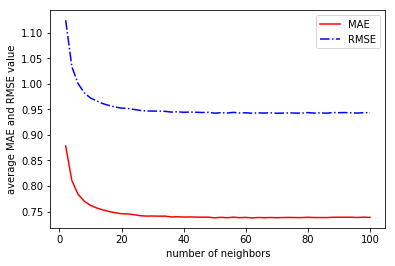

In [20]:
l1, = plt.plot(k_lst, mae_lst, 'r-', label='MAE')
l2, = plt.plot(k_lst, rmse_lst, 'b-.', label='RMSE')
plt.xlabel('number of neighbors')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 11

The minimum $k$ is about __12__. MAE converges to __0.74__ and RMSE converges to __0.94__.

#### Question 12

In [59]:
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold

In [73]:
def trim_popular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter <= 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter <= 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [74]:
def trim_unpopular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter > 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter > 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [ ]:
def trim_highvar(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    temp_r = []
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter < 5 or np.var(temp_r) < 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            temp_r = []
            lastm = m
        
        counter += 1
        temp_r.append(r)
        trimmed.append((u, m, r))

    if counter < 5 or np.var(temp_r) < 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [80]:
#test block
ratings_dict = {'userID': [9, 32, 2, 45, 4, 1, 5, 31, 21],
                'itemID': [1, 1, 1, 1, 1, 1, 1, 2, 2],
                'rating': [3.5, 2.5, 4.0, 1, 1, 1, 1, 3.5, 1.0]}
df1 = pd.DataFrame(ratings_dict)
reader1 = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data1 = Dataset.load_from_df(df1[['userID', 'itemID', 'rating']], reader1)

kf1 = KFold(n_splits=2)
for trainset, testset in kf1.split(data1):
    print(trim_popular(testset))

[[1, 1, 1.0], [5, 1, 1.0], [32, 1, 2.5], [45, 1, 1.0]]
[[2, 1, 4.0], [4, 1, 1.0], [9, 1, 3.5]]


In [85]:
kf = KFold(n_splits=10)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(r_data[['userId', 'movieId', 'rating']], reader)

rmse_pop = []
rmse_unpop = []
rmse_highvar = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop.pkl")\
                    and os.path.isfile("./rmse_unpop.pkl")\
                    and os.path.isfile("./rmse_highvar.pkl"):
    logging.info("Loading rmse_pop, rmse_unpop and rmse_highvar.")
    rmse_pop = pickle.load(open("./rmse_pop.pkl", "rb"))
    rmse_unpop = pickle.load(open("./rmse_unpop.pkl", "rb"))
    rmse_highvar = pickle.load(open("./rmse_highvar.pkl", "rb"))
else:
    for k in k_lst:
        rmse_temp_pop = []
        rmse_temp_unpop = []
        rmse_temp_highvar = []
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop = algo.test(trim_popular(testset))
            predictions_unpop = algo.test(trim_unpopular(testset))
            predictions_highvar = algo.test(trim_highvar(testset))
            rmse_temp_pop.append(accuracy.rmse(predictions_pop))
            rmse_temp_unpop.append(accuracy.rmse(predictions_unpop))
            rmse_temp_highvar.append(accuracy.rmse(predictions_highvar))
        rmse_pop.append(np.mean(rmse_temp_pop))
        rmse_unpop.append(np.mean(rmse_temp_unpop))
        rmse_highvar.append(np.mean(rmse_temp_highvar))

    pickle.dump(rmse_pop, open("./rmse_pop.pkl", "wb"))    
    pickle.dump(rmse_unpop, open("./rmse_unpop.pkl", "wb"))
    pickle.dump(rmse_highvar, open("./rmse_highvar.pkl", "wb"))

print(rmse_pop[:5])

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0502
RMSE: 1.0740
RMSE: 1.6732
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0489
RMSE: 1.0753
RMSE: 1.4789
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0493
RMSE: 1.0910
RMSE: 1.5500
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0531
RMSE: 1.0917
RMSE: 1.4896
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0432
RMSE: 1.0710
RMSE: 1.5538
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0367
RMSE: 1.0776
RMSE: 1.4657
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0490
RMSE: 1.0895
RMSE: 1.4997
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0537
RMSE: 1.0785
RMSE: 1.5489
Computing the pearson similarity matrix...
Done computing similarity mat

RMSE: 0.8852
RMSE: 0.9874
RMSE: 1.4612
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8772
RMSE: 1.0149
RMSE: 1.3778
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8864
RMSE: 0.9913
RMSE: 1.5111
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8876
RMSE: 1.0013
RMSE: 1.4402
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8847
RMSE: 0.9972
RMSE: 1.4159
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8822
RMSE: 1.0163
RMSE: 1.5087
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8729
RMSE: 1.0240
RMSE: 1.5103
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8796
RMSE: 1.0143
RMSE: 1.4681
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9003
RMSE: 0.9872
RMSE: 1.4104
Computing the pearson similarity 

RMSE: 0.8666
RMSE: 1.0272
RMSE: 1.3653
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8817
RMSE: 1.0137
RMSE: 1.4834
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8793
RMSE: 0.9914
RMSE: 1.3975
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8739
RMSE: 1.0235
RMSE: 1.3963
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8842
RMSE: 1.0110
RMSE: 1.3864
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8718
RMSE: 0.9930
RMSE: 1.4839
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8667
RMSE: 1.0147
RMSE: 1.4827
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8855
RMSE: 0.9967
RMSE: 1.3954
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8799
RMSE: 1.0042
RMSE: 1.5122
Computing the pearson similarity 

Done computing similarity matrix.
RMSE: 0.8851
RMSE: 0.9732
RMSE: 1.4566
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8976
RMSE: 1.0297
RMSE: 1.4309
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8738
RMSE: 1.0175
RMSE: 1.3571
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8662
RMSE: 1.0195
RMSE: 1.3083
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8660
RMSE: 1.0007
RMSE: 1.3592
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8653
RMSE: 1.0169
RMSE: 1.4623
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8669
RMSE: 1.0101
RMSE: 1.3963
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8762
RMSE: 1.0266
RMSE: 1.4768
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8683
RMSE: 0.9940
RMSE: 1.4566

Done computing similarity matrix.
RMSE: 0.8871
RMSE: 1.0009
RMSE: 1.2545
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8886
RMSE: 0.9979
RMSE: 1.4708
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8880
RMSE: 1.0087
RMSE: 1.4311
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8880
RMSE: 1.0026
RMSE: 1.4853
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8766
RMSE: 1.0059
RMSE: 1.3386
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8804
RMSE: 0.9960
RMSE: 1.4657
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8769
RMSE: 1.0298
RMSE: 1.4043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8869
RMSE: 1.0224
RMSE: 1.3393
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8720
RMSE: 1.0161
RMSE: 1.4488

Done computing similarity matrix.
RMSE: 0.8728
RMSE: 1.0012
RMSE: 1.5608
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8662
RMSE: 0.9916
RMSE: 1.4289
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8629
RMSE: 0.9939
RMSE: 1.5143
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8777
RMSE: 1.0110
RMSE: 1.3395
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8719
RMSE: 0.9901
RMSE: 1.3925
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8737
RMSE: 1.0223
RMSE: 1.3668
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8634
RMSE: 0.9975
RMSE: 1.3882
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8783
RMSE: 1.0287
RMSE: 1.5001
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8631
RMSE: 1.0144
RMSE: 1.4998

Done computing similarity matrix.
RMSE: 0.8807
RMSE: 1.0167
RMSE: 1.4316
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8707
RMSE: 1.0150
RMSE: 1.4937
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8728
RMSE: 1.0339
RMSE: 1.4088
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8651
RMSE: 1.0025
RMSE: 1.4645
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8813
RMSE: 1.0223
RMSE: 1.4364
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8735
RMSE: 1.0267
RMSE: 1.4283
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8820
RMSE: 1.0196
RMSE: 1.3664
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8885
RMSE: 1.0203
RMSE: 1.4397
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8744
RMSE: 0.9794
RMSE: 1.4376

Done computing similarity matrix.
RMSE: 0.8896
RMSE: 1.0181
RMSE: 1.4156
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8732
RMSE: 1.0135
RMSE: 1.4333
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8725
RMSE: 1.0128
RMSE: 1.4769
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8716
RMSE: 1.0333
RMSE: 1.3511
[1.0474940413149139, 0.95481980124888055, 0.92194934099151138, 0.90665093687839526, 0.89817706028640032]


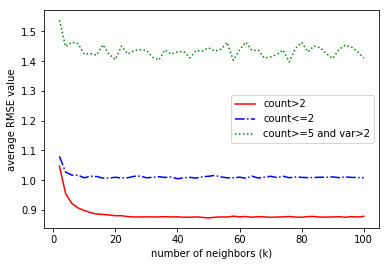

In [86]:
l1, = plt.plot(k_lst, rmse_pop, 'r-', label='count>2')
l2, = plt.plot(k_lst, rmse_unpop, 'b-.', label='count<=2')
l3, = plt.plot(k_lst, rmse_highvar, 'g:', label='count>=5 and var>2')
plt.xlabel('number of neighbors (k)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()